### Infotaxis summary
Based on the paper ['Infotaxis' as a strategy for searching without gradients](http://www.nature.com/nature/journal/v445/n7126/full/nature05464.html) by Vergassola, et al., 2007.

In the infotaxis algorithm a tracking agent attempts to localize the position of an odor source by moving so as to maximize information gain.

#### Source position distribution

Throughout its search trajectory $T_t$ (which includes the sequence of positions it has traversed and the "hits" it has experienced until time $t$) the agent maintains a probability map $P(\mathbf{r}_{src}|T_t)$ over where it thinks the source is, which has entropy

$$S_t = S[P(\mathbf{r}_{src}|T_t)] = -\sum \limits_{\mathbf{r}_{src}} P(\mathbf{r}_{src}|T_t) \log P(\mathbf{r}_{src}|T_t).$$

$P(\mathbf{r}_{src}|T_t)$ can be written using Bayes' law as

$$P(\mathbf{r}_{src}|T_t) = \cfrac{P(T_t|\mathbf{r}_{src})P(\mathbf{r}_{src})}{P(T_t)} \propto
P(T_t|\mathbf{r}_{src})P(\mathbf{r}_{src})$$

where $P(T_t|\mathbf{r}_{src})$ is the source position likelihood and $P(\mathbf{r}_{src})$ is the source position prior. The likelihood is based on the assumption that all hits and misses are independent of one another:

$$P(T_t|\mathbf{r}_{src}) = \prod \limits_t P(h(\mathbf{r}_t)|\mathbf{r}_{src})$$

where $h(\mathbf{r}_t)$ is 0 if the agent detected a miss at $\mathbf{r}_t$ at time $t$ and 1 if it detected a hit. We assume a Poisson distribution over the hit numbers (though the agent binarizes its detection so than any number of hits > 0 is just counted as 1). Thus

$$P(h(\mathbf{r}_t) = 0|\mathbf{r}_{src}) = \exp[-\lambda(\mathbf{r}_t, \mathbf{r}_{src})]$$

$$P(h(\mathbf{r}_t) > 0|\mathbf{r}_{src}) = 1 - P(h_t(\mathbf{r}_t) = 0|\mathbf{r}_{src})$$

where $\lambda(\mathbf{r}_t, \mathbf{r}_{src}) = R(\mathbf{r}_t, \mathbf{r}_{src})\Delta t$ is the mean number of hits the agent would expect at $\mathbf{r}_t$ in a time window $\Delta t$, given a source at $\mathbf{r}_{src}$. For a 2-D search environment, $R(\mathbf{r}_t, \mathbf{r}_{src})$ is given by Eq. 7 in the infotaxis paper's [supplementary information](http://www.nature.com/nature/journal/v445/n7126/suppinfo/nature05464.html) (note, however, that they have assumed the wind blows in the negative y-direction, whereas in our code we assume that it blows in the positive x-direction, i.e., -x is upwind and +x is downwind; also, their $\mathbf{r}_0$ is our $\mathbf{r}_{src}$). This is derived from the statistics of advected particles in a turbulent medium.

Note that the form of $P(T_t|\mathbf{r}_{src})$ is useful because it allows for recursive updating:

$$P(\mathbf{r}_{src}|T_{t+1}) = P(h(\mathbf{r}_{t+1})|\mathbf{r}_{src}) P(\mathbf{r}_{src}|T_t)$$

or in log units:

$$\log P(\mathbf{r}_{src}|T_{t+1}) = \log P(h(\mathbf{r}_{t+1})|\mathbf{r}_{src}) + \log P(\mathbf{r}_{src}|T_t).$$

#### Movement policy

At each time step the agent considers 5 possible moves: forward, backward, left, right, and wait.

For each move it first calculates the probability that it finds the source after that move:

$$p_{\textrm{src found}} = \sum \limits_{\mathbf{r}_{src}} P(\mathbf{r}_{src}|T_t)P(\textrm{dist to }\mathbf{r}_{src}\textrm{ after move} < \textrm{detection radius})$$

with $p_{\textrm{src not found}} = 1 - p_{\textrm{src found}}.$ If it finds the source the entropy $S$ of the source distribution will go to zero, i.e., $\Delta S_{\textrm{src found}} = -S_t$.

The agent considers the case that it doesn't find the source after making that move. In this case it will either sample a miss or a hit. First it calculates the probability of sampling a miss $p_{miss}$ and the probability of sampling a hit $p_{hit} = 1 - p_{miss}$ should it make that move. $p_{miss}$ is calculated by averaging the miss probability over all possible source locations:

$$p_{miss} = \sum \limits_{\mathbf{r}_{src}}P_{miss}(\mathbf{r'}, \mathbf{r}_{src})
P(\mathbf{r}_{src}|T_t) =
\sum \limits_{\mathbf{r}_{src}}P(h(\mathbf{r'}) = 0|\mathbf{r}_{src})
P(\mathbf{r}_{src}|T_t)
$$

where $\mathbf{r'}$ is the position the agent would be at if it were to make that move. 

The agent then calculates how its source position distribution would change, and specifically how the entropy of the source position distribution would change, were it to make that move. According to the update rule above, for a miss at $\mathbf{r'}$ this is given by:

$$P(\mathbf{r}_{src}|T_{t}, \textrm{miss at } \mathbf{r'}) = P(h(\mathbf{r'}) = 0|\mathbf{r}_{src}) P(\mathbf{r}_{src}|T_t)$$

and for a hit:

$$P(\mathbf{r}_{src}|T_{t}, \textrm{hit at } \mathbf{r'}) = P(h(\mathbf{r'}) = 1|\mathbf{r}_{src}) P(\mathbf{r}_{src}|T_t)$$

The entropy given a miss is:

$$s_{miss} = S[P(\mathbf{r}_{src}|T_{t}, \textrm{miss at } \mathbf{r'})] = -\sum \limits_{\mathbf{r}_{src}} P(\mathbf{r}_{src}|T_{t}, \textrm{miss at } \mathbf{r'}) \log P(\mathbf{r}_{src}|T_{t}, \textrm{miss at } \mathbf{r'})$$

and given a hit:

$$s_{hit} = S[P(\mathbf{r}_{src}|T_{t}, \textrm{hit at } \mathbf{r'})] = -\sum \limits_{\mathbf{r}_{src}} P(\mathbf{r}_{src}|T_{t}, \textrm{hit at } \mathbf{r'}) \log P(\mathbf{r}_{src}|T_{t}, \textrm{hit at } \mathbf{r'}).$$

Having calculated these quantities for the move in question, the agent calculates the total expected change in entropy should it make its move and not find the source:

$$\Delta S_{\textrm{src not found}} = p_{miss}(s_{miss} - S_t) + p_{hit}(s_{hit} - S_t).$$

Finally, for it calculates the full expected entropy change for the move:

$$\Delta S_{full}(\textrm{move}) = p_{\textrm{src found}}\Delta S_\textrm{src found} + p_{\textrm{src not found}}\Delta S_{\textrm{src not found}}.$$

To choose where to move, the agent simply picks the move that decreases the entropy of the source position distribution the most:

$$\textrm{chosen move} = \textrm{argmin}_{\textrm{move}} \left(\Delta S_{full}(\textrm{move})\right).$$

After it makes its move, it samples either a miss or a hit from the real plume, updates the source position distribution accordingly, and then goes through the move selection process once again. And so on until it finds the source.

Below we go through some tests and demonstrations of the algorithm to ensure that it is working correctly.

### Run some automated tests
These will throw an error upon failure.

In [1]:
from tests.test_infotaxis import test_get_p_src_found_returns_correct_probabilities_for_examples
from tests.test_infotaxis import test_get_p_sample_works_qualitatively_for_examples

test_get_p_src_found_returns_correct_probabilities_for_examples()
test_get_p_sample_works_qualitatively_for_examples()

### Look at the hit rate map as a function of source position
The hit rate should be highest at the sample position (green diamond). The white arrow indicates the wind direction.

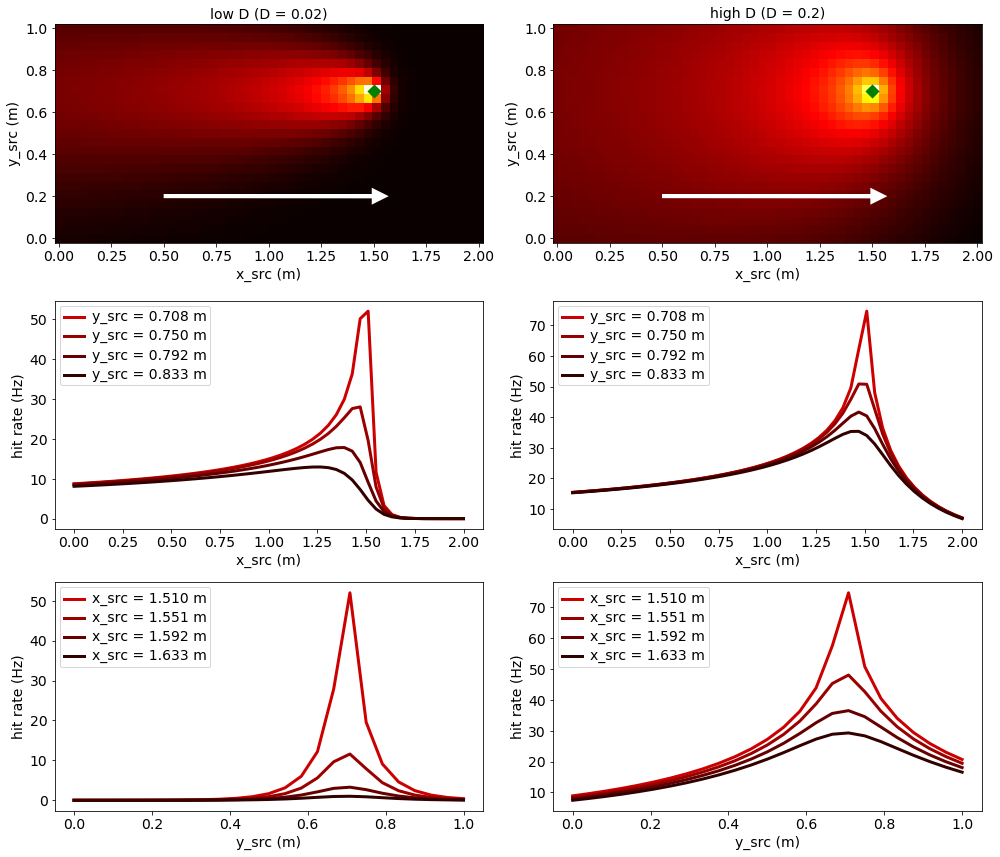

In [2]:
%matplotlib inline
from tests.test_infotaxis import show_hit_rate_map_for_example_parameters

show_hit_rate_map_for_example_parameters()

### Make sure the posterior is getting updated correctly after miss and hit

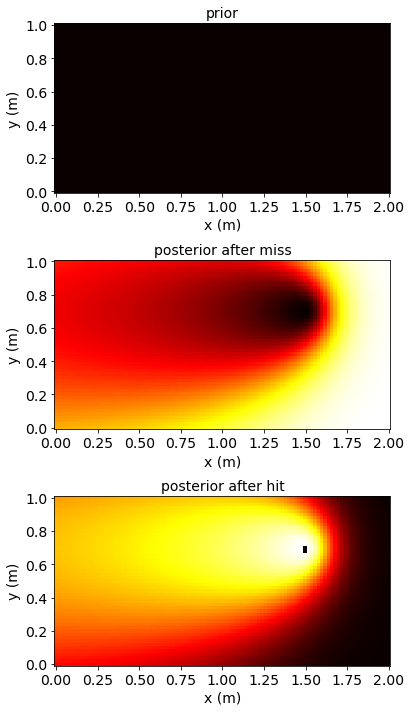

In [3]:
%matplotlib inline
from tests.test_infotaxis import show_update_log_p_src_gives_correct_qualitative_behavior_for_examples

show_update_log_p_src_gives_correct_qualitative_behavior_for_examples()

### Demo the full infotaxis algorithm on an ideal plume
The large plot on top shows the full trajectory (starting at blue circle), with hit marked hit locations (cyan diamonds), overlaid on the plume's time-averaged concentration profile given a source position at the black star.

The subsequent plots show the trajectory at different time points during the search, overlaid on the current posterior distribution over source positions.

Source found after 175 time steps (17.5 s)


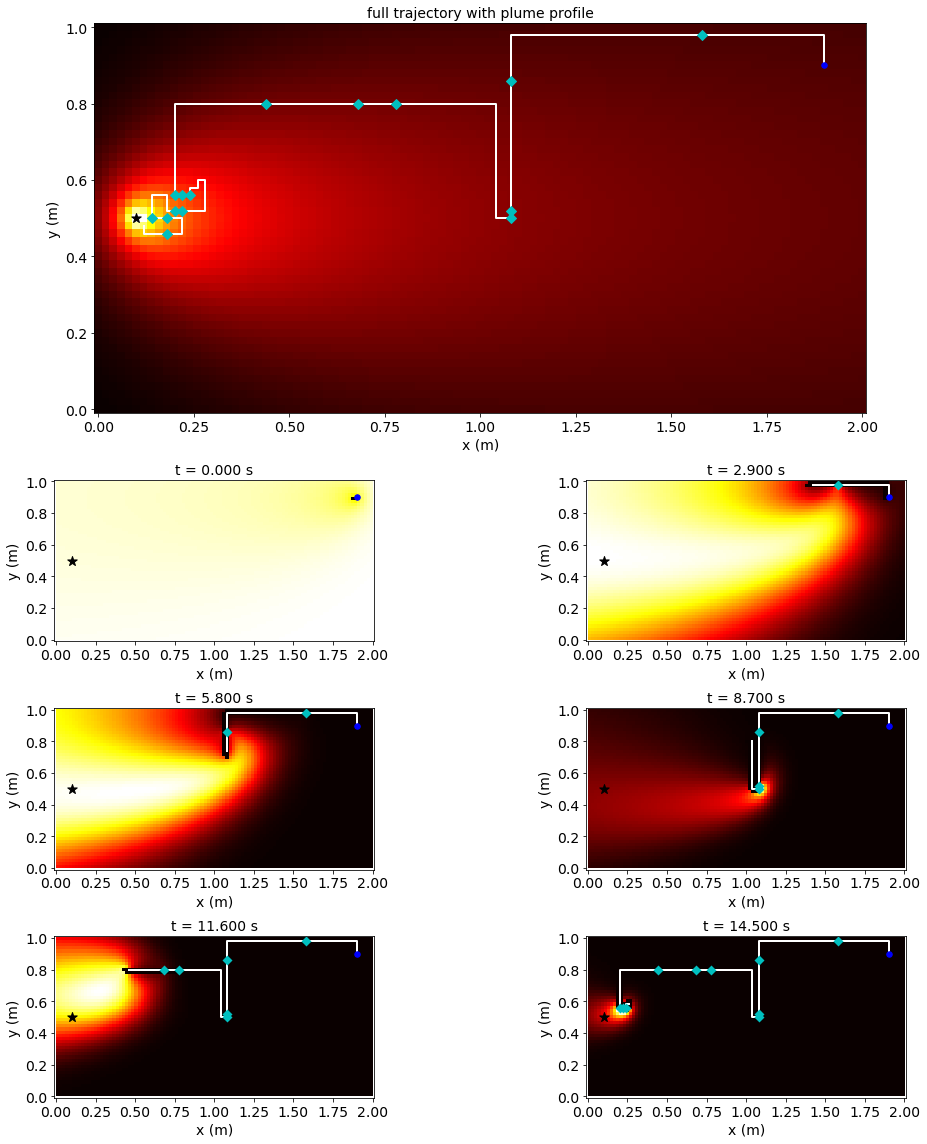

In [4]:
%matplotlib inline
from tests.test_infotaxis import show_infotaxis_demo

show_infotaxis_demo()